<a href="https://colab.research.google.com/github/Garimagupta85/Default-Prediction/blob/main/EDA_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import gc
from itertools import compress
from sklearn.metrics import accuracy_score  
from sklearn.metrics import precision_score                         
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix

import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

NULL_VALUES_THRESHOLD = 0.95

## Loading Data 

In [2]:
#loading amex data (parquet form) from google drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

train_file_id = '1JKPJVwQjn72xuXjFpz_DQy6MZtbNFg_2' 
test_file_id = '1ADD4KUHP4nSz_-YBEFClD1DTpSZhmMM-'
train_labels_file_id = '1kEh1YWz1xyHifimo_3y5vzyNEV_Lk0ZA'

download = drive.CreateFile({'id': train_file_id})
# Download the training data to a local disc
#download.GetContentFile('train-data.parquet')
train_data  = pd.read_parquet("train-data.parquet")
train_data.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,...,NaN,NaN,0.003954,0.003167,0.005032,NaN,0.009576,0.005492,0.009217,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,...,NaN,NaN,0.003269,0.007329,0.000427,NaN,0.003429,0.006986,0.002603,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,0.005531,...,NaN,NaN,0.006117,0.004516,0.003200,NaN,0.008419,0.006527,0.009600,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,0.009312,...,NaN,NaN,0.003671,0.004946,0.008889,NaN,0.001670,0.008126,0.009827,0


In [ ]:
# download = drive.CreateFile({'id': test_file_id})
# # Download the test data to a local disc
# download.GetContentFile('test-data.parquet')
test_data  = pd.read_parquet("test-data.parquet")
test_data.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-02-19,0.631315,0.001912,0.010728,0.814497,0.007547,0.168651,0.009971,0.002347,...,NaN,NaN,NaN,NaN,0.004669,NaN,NaN,NaN,0.008281,NaN
1,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-03-25,0.587042,0.005275,0.011026,0.810848,0.001817,0.241389,0.000166,0.009132,...,NaN,NaN,NaN,0.000142,0.004940,0.009021,NaN,0.003695,0.003753,0.001460
2,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-04-25,0.609056,0.003326,0.016390,1.004620,0.000114,0.266976,0.004196,0.004192,...,NaN,NaN,NaN,0.000074,0.002114,0.004656,NaN,0.003155,0.002156,0.006482
3,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-05-20,0.614911,0.009065,0.021672,0.816549,0.009722,0.188947,0.004123,0.015325,...,NaN,NaN,NaN,0.004743,0.006392,0.002890,NaN,0.006044,0.005206,0.007855
4,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-06-15,0.591673,0.238794,0.015923,0.810456,0.002026,0.180035,0.000731,0.011281,...,NaN,NaN,NaN,0.008133,0.004329,0.008384,NaN,0.001008,0.007421,0.009471


In [ ]:
# # download = drive.CreateFile({'id': train_labels_file_id})
# # # Download the training labels to a local disc
# # download.GetContentFile('train-labels-data.csv')
# train_labels_data  = pd.read_csv("train-labels-data.csv")
# train_labels_data.head()

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0


## Preprocessing the data

In [4]:
train_data.shape

(5531451, 191)

In [5]:
print(f'Train dates range is from {train_data["S_2"].min()} to {train_data["S_2"].max()}.')

Train dates range is from 2017-03-01 to 2018-03-31.


In [6]:
categorical_features = ['B_30', 'B_38', 'D_63', 'D_64', 'D_66', 'D_68', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126']
train_data[categorical_features] = train_data[categorical_features].astype("category")
train_data[categorical_features].dtypes

B_30     category
B_38     category
D_63     category
D_64     category
D_66     category
D_68     category
D_114    category
D_116    category
D_117    category
D_120    category
D_126    category
dtype: object

In [7]:
train_data.columns

Index(['customer_ID', 'S_2', 'P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41',
       'B_3',
       ...
       'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143', 'D_144',
       'D_145', 'target'],
      dtype='object', length=191)

## EDA

In [8]:
f_Del = [c for c in train_data.columns if c.startswith('D_')]
f_Spd = [c for c in train_data.columns if c.startswith('S_')]
f_Pay = [c for c in train_data.columns if c.startswith('P_')]
f_Bal = [c for c in train_data.columns if c.startswith('B_')]
f_Risk = [c for c in train_data.columns if c.startswith('R_')]
print(f'Total number of Delinquency variables: {len(f_Del)}')
print(f'Total number of Spend variables: {len(f_Spd)}')
print(f'Total number of Payment variables: {len(f_Pay)}')
print(f'Total number of Balance variables: {len(f_Bal)}')
print(f'Total number of Risk variables: {len(f_Risk)}')

Total number of Delinquency variables: 96
Total number of Spend variables: 22
Total number of Payment variables: 3
Total number of Balance variables: 40
Total number of Risk variables: 28


In [9]:
labels=['Delinquency', 'Spend','Payment','Balance','Risk']
values= [len(f_Del), len(f_Spd),len(f_Pay), len(f_Bal),len(f_Risk)]

In [10]:
fig = go.Figure()
fig.add_trace(go.Pie(values = values,labels = labels,hoverinfo ='label+percent', hole = 0.6, 
))
fig.update_traces(textfont_size = 13,showlegend = False, hoverinfo ='label+percent',textinfo ='label', 
                  title = dict(text = 'Feature Distribution'))  
fig.show()

In [11]:
missing_values = train_data.isna().sum()
print("Total missing values" , sum(missing_values))

Total missing values 160858968


In [12]:
#Custom Color Palette 
custom_colors = ["#ffd670","#70d6ff","#ff4d6d","#8338ec","#90cf8e"]
customPalette = sns.set_palette(sns.color_palette(custom_colors))

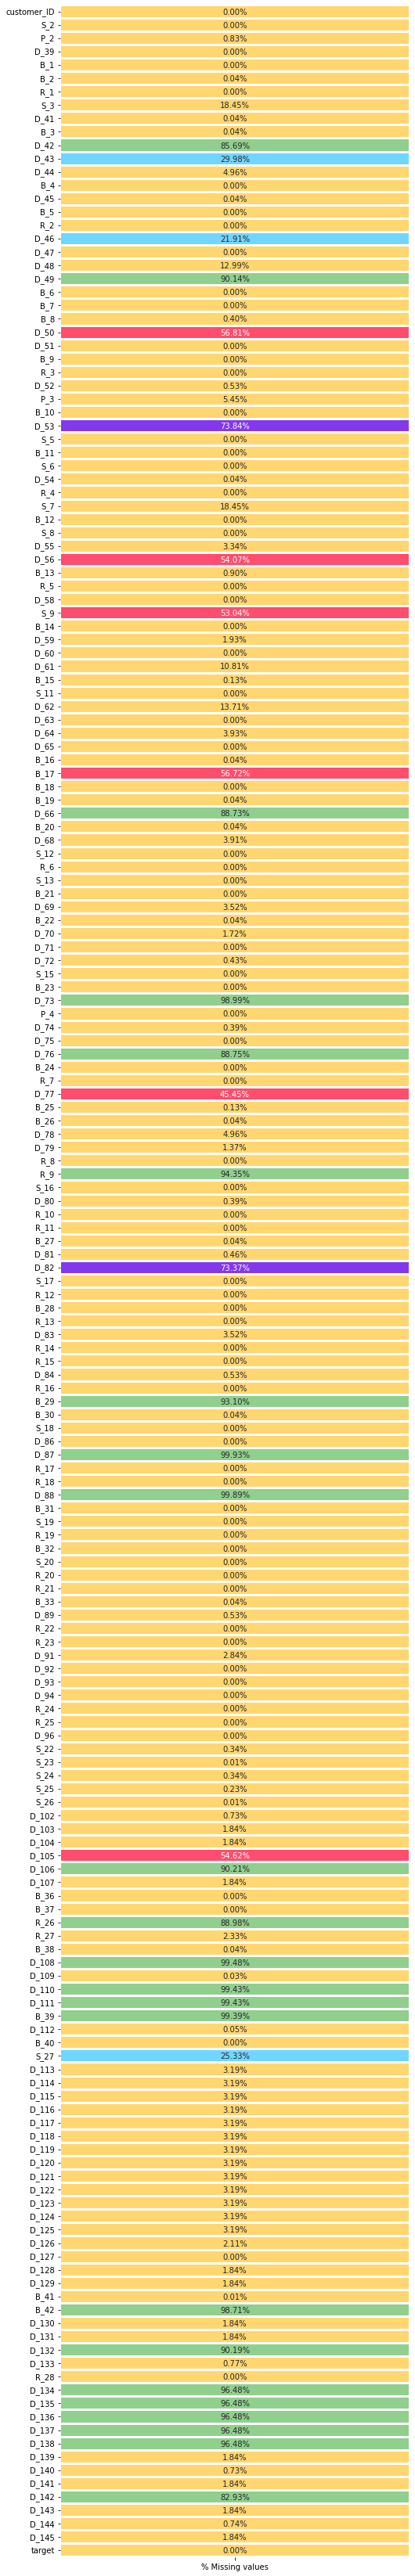

In [13]:
missing = pd.DataFrame(columns = ['% Missing values'],data = train_data.isnull().sum()/len(train_data))
fig = plt.figure(figsize = (20, 60),facecolor='white')
gs = fig.add_gridspec(1, 2)
gs.update(wspace = 0.5, hspace = 0.5)
ax0 = fig.add_subplot(gs[0, 0])
for s in ["right", "top","bottom","left"]:
    ax0.spines[s].set_visible(False)
sns.heatmap(missing,cbar = False,annot = True,fmt =".2%", linewidths = 2,cmap = custom_colors,vmax = 1, ax = ax0)
plt.show()

In [14]:
stat_plot = train_data.reset_index().groupby('S_2')['customer_ID'].nunique().reset_index()
fig = go.Figure()
fig.add_trace(go.Scatter(x = stat_plot['S_2'], y = stat_plot['customer_ID']))
fig.update_layout(title="Customer Statements", width = 800, height = 600,xaxis_title ='Statement Date',
                  paper_bgcolor='rgb(0,0,0,0)',plot_bgcolor='rgb(0,0,0,0)') 
fig['data'][0]['line']['color']="#ff9770"
fig.show()

In [15]:
import gc
gc.collect()

438

In [16]:
target_class = pd.DataFrame({'count': train_data['target'].value_counts(),
                             'percentage': train_data['target'].value_counts() / train_data.shape[0] * 100
})

target_class

,count,percentage
0,4153582,75.090279
1,1377869,24.909721


In [17]:
fig = go.Figure()
fig.add_trace(go.Pie(values = target_class['count'],labels = target_class.index,hole = 0.6, 
                     hoverinfo ='label+percent'))
fig.update_traces(textfont_size = 12, hoverinfo ='label+percent',textinfo ='label', 
                  showlegend = False,
                  title = dict(text = 'Target Distribution'))  
fig.show()

In [19]:
default_class = train_data[train_data['target']==1]
default_class.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
104,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-03-15,0.400025,0.000278,0.954861,0.023890,0.003140,NaN,0.008421,1.175081,...,NaN,NaN,1.002518,0.001170,0.870115,0.141214,1.003923,0.008945,0.736632,1
105,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-04-14,0.405788,0.000269,0.944042,0.025613,0.008950,NaN,0.003707,1.177973,...,NaN,NaN,1.005944,0.003116,0.864712,0.145885,1.004833,0.002125,0.733311,1
106,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-05-15,0.403615,0.032850,0.940261,0.026016,0.009074,NaN,0.008000,1.175785,...,NaN,NaN,1.006883,0.004455,0.871729,0.144555,1.000521,0.000765,0.729252,1
107,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-06-14,0.391495,0.034461,0.936253,0.029538,0.005778,NaN,0.002849,1.174703,...,NaN,NaN,1.000132,0.002175,0.869414,0.151890,1.001034,0.008195,0.727660,1
108,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-07-15,0.392356,0.037955,0.915764,0.028671,0.008595,NaN,0.002428,1.177958,...,NaN,NaN,1.001192,0.004609,0.869089,0.152654,1.007116,0.001493,0.727649,1


In [20]:
paid_class = train_data[train_data['target']==0]
paid_class.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,...,NaN,NaN,0.003954,0.003167,0.005032,NaN,0.009576,0.005492,0.009217,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,...,NaN,NaN,0.003269,0.007329,0.000427,NaN,0.003429,0.006986,0.002603,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,0.005531,...,NaN,NaN,0.006117,0.004516,0.003200,NaN,0.008419,0.006527,0.009600,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,0.009312,...,NaN,NaN,0.003671,0.004946,0.008889,NaN,0.001670,0.008126,0.009827,0


In [21]:
del_cols = [c for c in train_data.columns if (c.startswith(('D','t'))) & (c not in categorical_features)]
df_del = train_data[del_cols]
spd_cols = [c for c in train_data.columns if (c.startswith(('S','t'))) & (c not in categorical_features)]
df_spd = train_data[spd_cols]
pay_cols = [c for c in train_data.columns if (c.startswith(('P','t'))) & (c not in categorical_features)]
df_pay = train_data[pay_cols]
bal_cols = [c for c in train_data.columns if (c.startswith(('B','t'))) & (c not in categorical_features)]
df_bal = train_data[bal_cols]
ris_cols = [c for c in train_data.columns if (c.startswith(('R','t'))) & (c not in categorical_features)]
df_ris = train_data[ris_cols]

### Feature correlation in default class

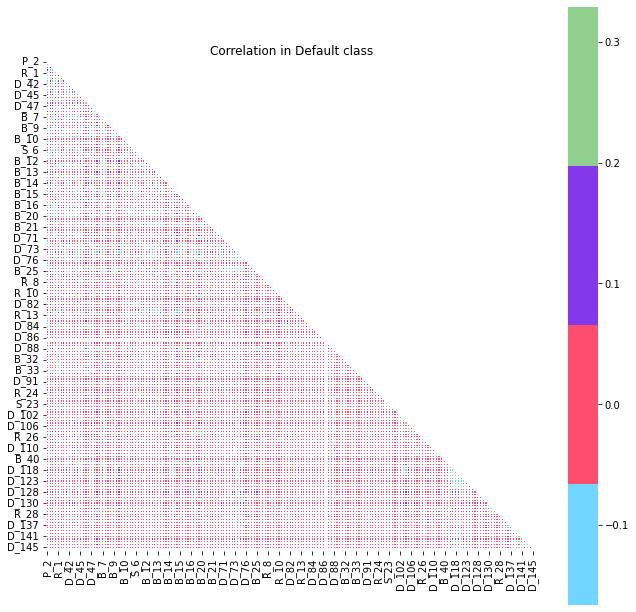

In [22]:
custom_colors = ["#ffd670","#70d6ff","#ff4d6d","#8338ec","#90cf8e"]
customPalette = sns.set_palette(sns.color_palette(custom_colors))

plt.figure(figsize =(11,11))
corr = default_class.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(corr, mask = mask, robust = True, center = 0,square = True, linewidths =.6, cmap = custom_colors)
plt.title('Correlation in Default class')
plt.show()

### Feature correlation in paid class

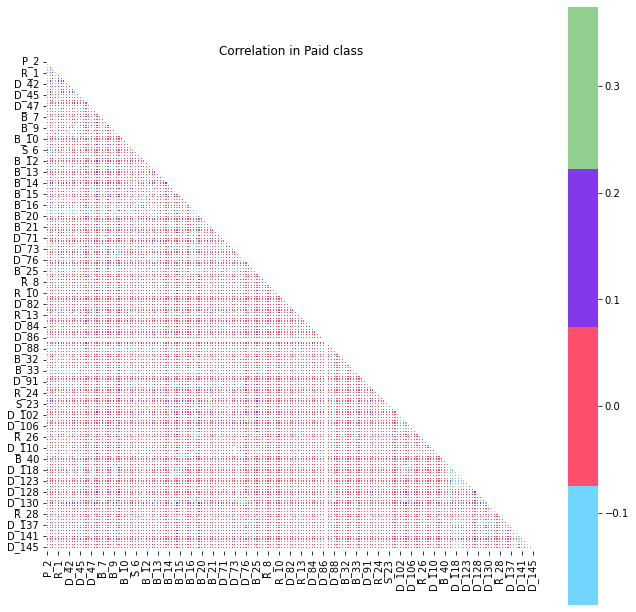

In [23]:
plt.figure(figsize =(11,11))
corr = paid_class.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(corr, mask = mask, robust = True, center = 0,square = True, linewidths =.6, cmap = custom_colors)
plt.title('Correlation in Paid class')
plt.show()

### Correlation between different variable types with themselves

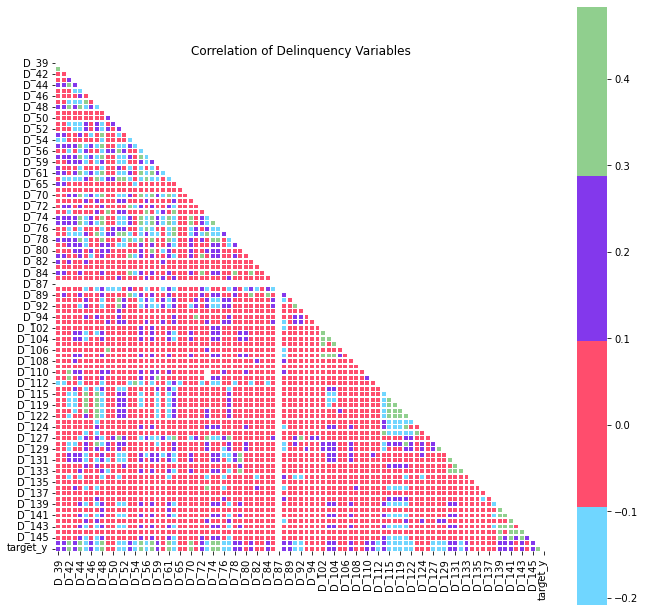

In [ ]:
plt.figure(figsize =(11,11))
corr = df_del.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(corr, mask = mask, robust = True, center = 0,square = True, linewidths =.6, cmap = custom_colors)
plt.title('Correlation between Delinquency Variables')
plt.show()

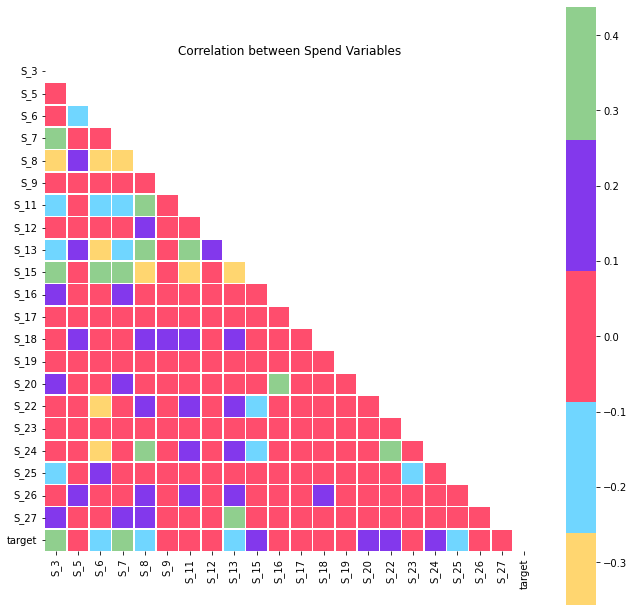

In [39]:
plt.figure(figsize =(11,11))
corr = df_spd.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(corr, mask = mask, robust = True, center = 0,square = True, linewidths =.6, cmap = custom_colors)
plt.title('Correlation between Spend Variables')
plt.show()

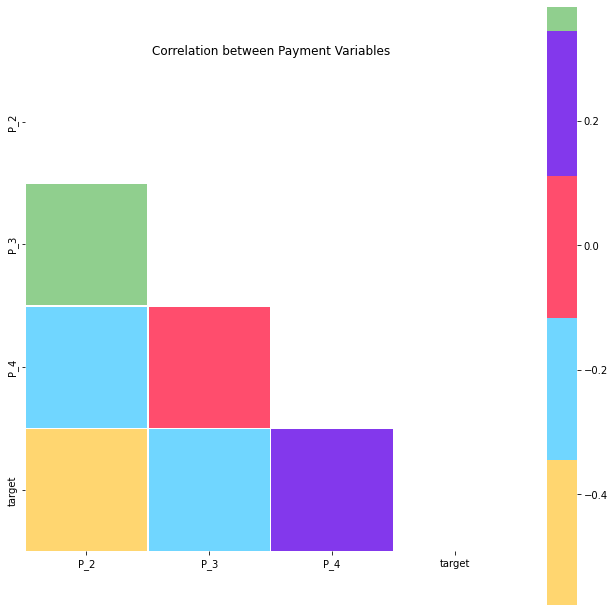

In [40]:
plt.figure(figsize =(11,11))
corr = df_pay.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(corr, mask = mask, robust = True, center = 0,square = True, linewidths =.6, cmap = custom_colors)
plt.title('Correlation between Payment Variables')
plt.show()

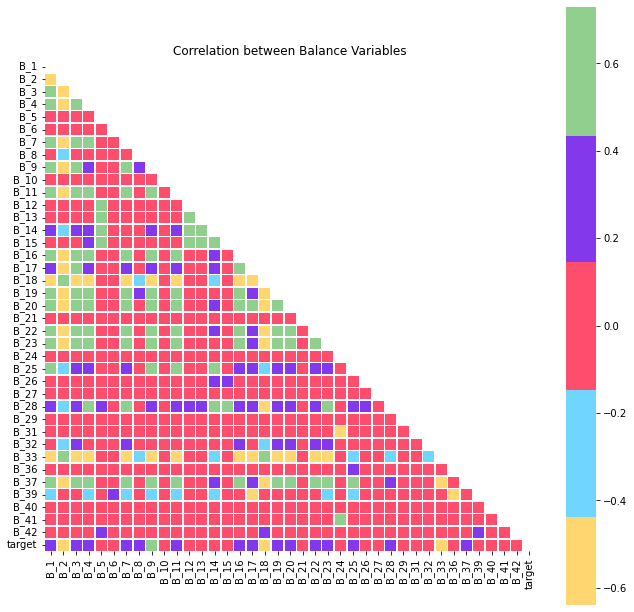

In [41]:
plt.figure(figsize =(11,11))
corr = df_bal.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(corr, mask = mask, robust = True, center = 0,square = True, linewidths =.6, cmap = custom_colors)
plt.title('Correlation between Balance Variables')
plt.show()

### Dependency of different variable types on payment variables

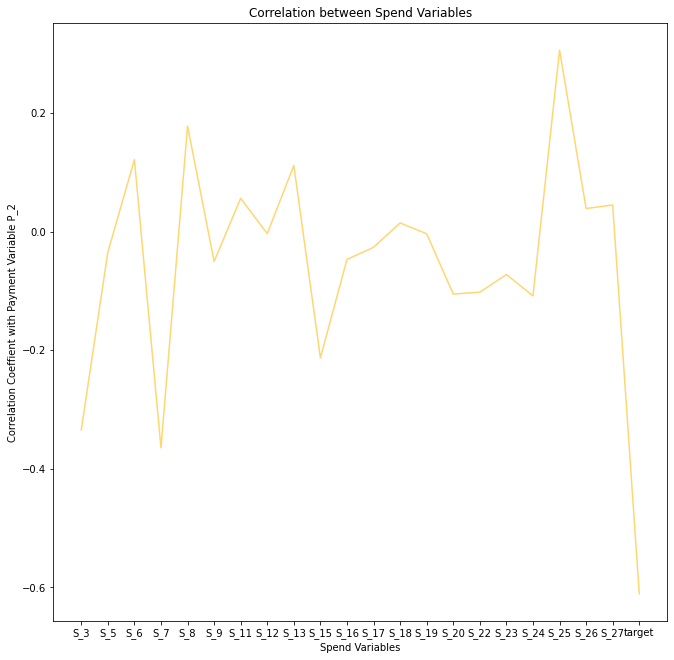

In [65]:
plt.figure(figsize =(11,11))
corr = df_spd.corrwith(df_pay.P_2)
mask = np.triu(np.ones_like(corr, dtype = bool))
plt.plot(corr)
plt.xlabel("Spend Variables")
plt.ylabel("Correlation Coeffient with Payment Variable P_2")
plt.title('Correlation between Spend Variables')
plt.show()

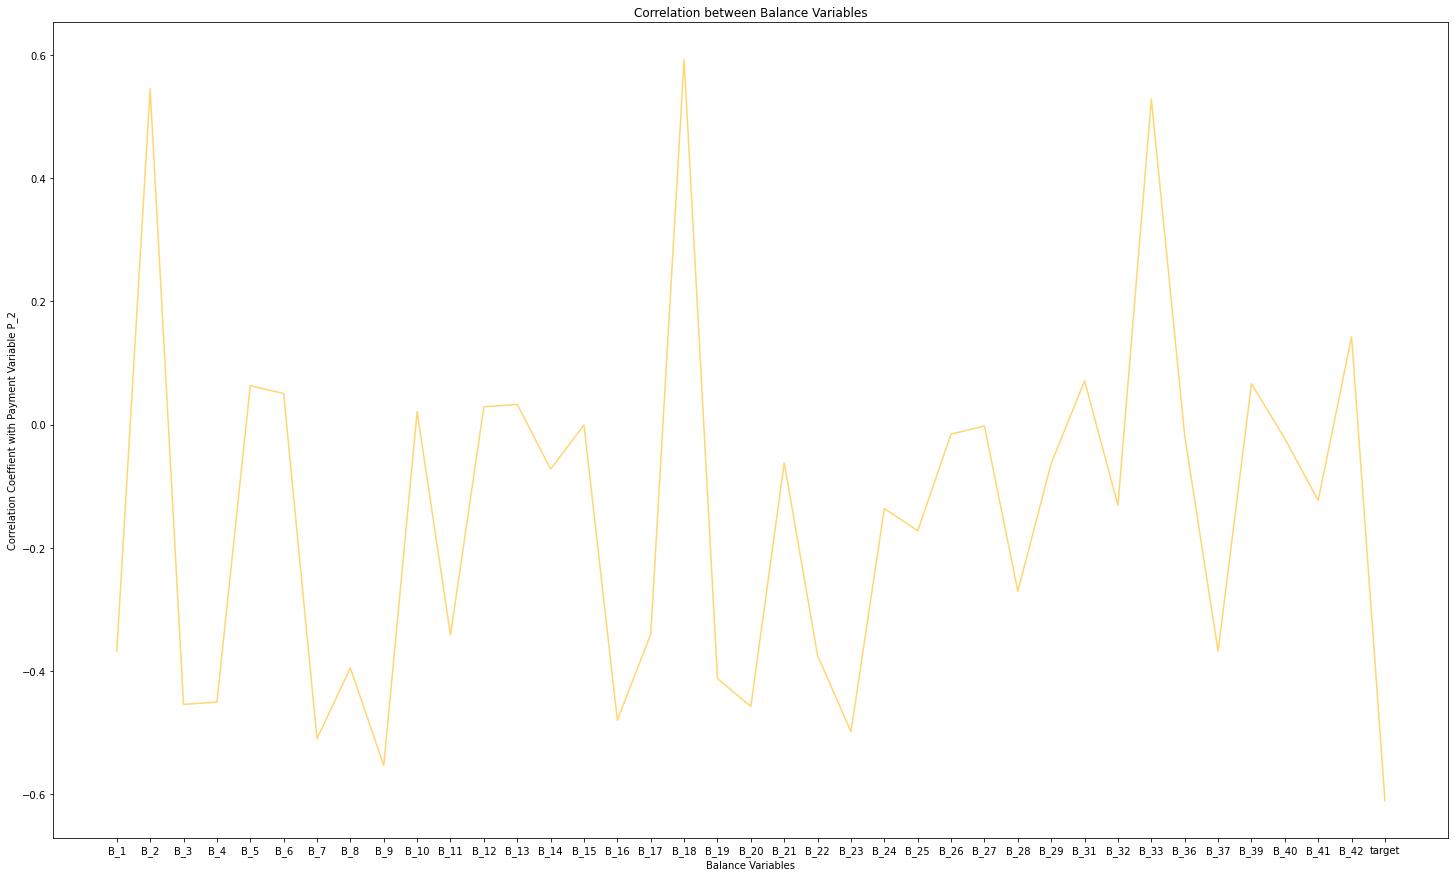

In [70]:
plt.figure(figsize =(25,15))
corr = df_bal.corrwith(df_pay.P_2)
plt.plot(corr)
plt.xlabel("Balance Variables")
plt.ylabel("Correlation Coeffient with Payment Variable P_2")
plt.title('Correlation between Balance Variables')
plt.show()

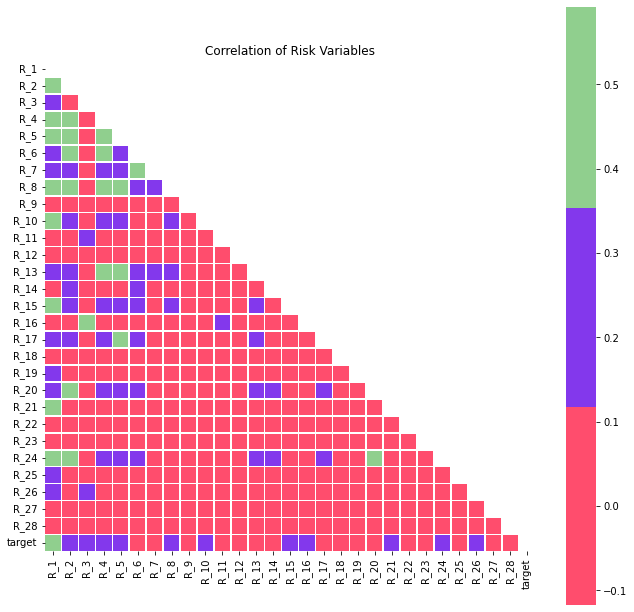

In [32]:
plt.figure(figsize =(11,11))
corr = df_ris.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
plt.plot(corr)
plt.xlabel("Risk Variables")
plt.ylabel("Correlation Coeffient with Payment Variable P_2")
plt.title('Correlation between Risk Variables')
plt.show()

## Preprocessing data for training model

In [ ]:
#remove colmuns that have more then THRESHOLD precent of missing values
print(train_data.shape)
train_data = train_data.dropna(axis=1, thresh=int(NULL_VALUES_THRESHOLD*train_data.shape[0]))
print(train_data.shape)

(5531451, 191)
(5531451, 151)


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5531451 entries, 0 to 5531450
Columns: 151 entries, customer_ID to target
dtypes: category(10), float32(137), int64(2), object(2)
memory usage: 3.1+ GB


In [ ]:
train_data = train_data.dropna()
print(train_data.shape)

(4825496, 151)


In [ ]:
cat_cols = ['customer_ID', 'S_2', 'B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_68']

In [ ]:
from sklearn.preprocessing import LabelEncoder
lab_enc = LabelEncoder()
for cat_feat in cat_cols:
    # train_data[cat_feat] = lab_enc.fit_transform(train_data[cat_feat])
    test_data[cat_feat] = lab_enc.fit_transform(test_data[cat_feat])

In [ ]:
# define dataset
X = train_data.drop('target', axis=1)
y = train_data['target']

In [ ]:
from sklearn.model_selection import train_test_split

# creating dataset split for prediction
X_train, X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=42) # 80-20 split

# Checking split 
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (3860396, 150)
y_train: (3860396,)
X_test: (965100, 150)
y_test: (965100,)


In [ ]:
X_train.dtypes != 'float32'

customer_ID     True
S_2             True
P_2            False
D_39           False
B_1            False
               ...  
D_140          False
D_141          False
D_143          False
D_144          False
D_145          False
Length: 150, dtype: bool

In [ ]:
X_train.isna().any()

customer_ID    False
S_2            False
P_2            False
D_39           False
B_1            False
               ...  
D_140          False
D_141          False
D_143          False
D_144          False
D_145          False
Length: 150, dtype: bool

## Training

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 2.6 MB/s 


In [ ]:
from catboost import CatBoostClassifier
clf = CatBoostClassifier(iterations = 3000, random_state = 42, nan_mode ='Min',task_type ="GPU")
clf.fit(X_train, y_train, eval_set = [(X_test, y_test)], cat_features=cat_cols,  verbose = 100)
preds = clf.predict_proba(X_test)[:, 1]

Learning rate set to 0.022394
0:	learn: 0.6314577	test: 0.6280407	best: 0.6280407 (0)	total: 116ms	remaining: 5m 47s
100:	learn: 0.0328036	test: 0.0006152	best: 0.0006152 (100)	total: 10.3s	remaining: 4m 56s
200:	learn: 0.0311525	test: 0.0005767	best: 0.0005767 (200)	total: 20.5s	remaining: 4m 45s
300:	learn: 0.0306247	test: 0.0005633	best: 0.0005633 (299)	total: 31.1s	remaining: 4m 38s
400:	learn: 0.0303263	test: 0.0005555	best: 0.0005554 (396)	total: 42.3s	remaining: 4m 34s
500:	learn: 0.0300650	test: 0.0005510	best: 0.0005510 (498)	total: 53.8s	remaining: 4m 28s
600:	learn: 0.0298418	test: 0.0005454	best: 0.0005454 (600)	total: 1m 5s	remaining: 4m 19s
700:	learn: 0.0296793	test: 0.0005422	best: 0.0005422 (698)	total: 1m 16s	remaining: 4m 11s
800:	learn: 0.0295069	test: 0.0005404	best: 0.0005403 (798)	total: 1m 28s	remaining: 4m 2s
900:	learn: 0.0293778	test: 0.0005386	best: 0.0005386 (899)	total: 1m 39s	remaining: 3m 52s
1000:	learn: 0.0292535	test: 0.0005359	best: 0.0005359 (999)	t

## Evaluation

In [ ]:
preds = clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# print accuracy
print("Accuracy: ", accuracy_score(y_test, preds))

# print precision, recall, F1-score per each class/tag
print(classification_report(y_test, preds))

# print confusion matrix, check documentation for sorting rows/columns
print(confusion_matrix(y_test, preds))


Accuracy:  0.9997824059682935
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    733049
           1       1.00      1.00      1.00    232051

    accuracy                           1.00    965100
   macro avg       1.00      1.00      1.00    965100
weighted avg       1.00      1.00      1.00    965100

[[732941    108]
 [   102 231949]]
